In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy import stats, linalg
import subprocess
import argparse
import json
import sys

In [2]:
def linear_model(ica_table, noise_regress_table, polort=True, TestRegress=None):
    """
    Compute Linear Model and calculate F statistics and P values for combinations of regressors

    Equation: Y = XB + E
    - Y = each ICA component (ica_table)
    - X = Design (Regressor) matrix (subsets of noise_regress_table)
    - B = Weighting Factors (solving for B)
    - E = errors (Y - Y_pred OR Y - XB)

    Input:
        ica_table: A DataFrame with the ICA mixing matrix
        noise_regress_table: A DataFrame with the noise regressor models
        polort: Add polynomial detrending regressors to the linear model
        TestRegress: A Dictionary that groups parts of regressors names in noise_regress_table with common element
           For example, there can be "Motion": {"_dmn", "_drv"} to say take all columns with _dmn and _drv and
           calculate an F value for them together.

    Output: Right now figures, but working on that part

    """

    Y = ica_table.to_numpy()
    n_time, n_icacomp = Y.shape

    # create polynomial detrending regressors
    if polort:
        n_polort = 4
        detrend_regressors = np.zeros((n_time, n_polort))
        for idx in range(n_polort):
            tmp = np.linspace(-1, 1, num=n_time)**idx
            if idx > 0:
                detrend_regressors[:,idx] = stats.zscore(tmp)
            else:
                detrend_regressors[:,idx] = tmp
        # plt.plot(detrend_regressors)
        # plt.show()

    # This next bloc of code is ugly and should probably be made into a separate function
    # or even more probably redesigned to not make this so hard. Still, it works.
    # The basic idea is we have a list of regressors categories like, motion.
    #  Look at the column titles for the regressors and select all regressors that match
    # a pattern in the column titles.
    # Identify the regressors in the model to include in the full model test
    All_labels = set()
    for tmpvals in TestRegress.values():
        All_labels.update(tmpvals)

    # Identify all regressors, but exclude motion regressors
    Labels_without_motion = set()
    for reg_types in ["Phys_Freq", "Phys_Variability", "WM & CSF"]:
        Labels_without_motion.update(TestRegress[reg_types])

    # Get a list of the column indices for all columns in the noise_regress_table that should be used
    # for each set of regressors.
    regress_labels = noise_regress_table.columns
    regress_all_colidx = set()
    regress_nomotion_colidx = set()
    for idx, reg_lab in enumerate(regress_labels):
        for use_lab in All_labels:
            if use_lab in reg_lab:
                regress_all_colidx.add(idx)
        for use_lab in Labels_without_motion:
            if use_lab in reg_lab:
                regress_nomotion_colidx.add(idx)              
    regress_all_colidx = list(regress_all_colidx)
    regress_nomotion_colidx = list(regress_nomotion_colidx)

    # At this point, regress_of_interest_full has all regressors in the model and
    #  regress_of_interest_nomotion has all the regressors excluding the motion ones
    regress_of_interest_full = stats.zscore(noise_regress_table.iloc[:,regress_all_colidx].to_numpy(), axis=0)
    regress_of_interest_nomotion = stats.zscore(noise_regress_table.iloc[:,regress_nomotion_colidx].to_numpy(), axis=0)

    # Full_Model is all regressors including the polort detrending regressors
    Full_Model = np.concatenate((detrend_regressors, regress_of_interest_full), axis=1)
    # NoMotoin_Model is all regressors EXCEPT motion regressors, and including the polort detrending regressors
    NoMotion_Model = np.concatenate((detrend_regressors, regress_of_interest_nomotion), axis=1)
    print(f"Full_Model {Full_Model.shape}")
    print(f"detrend_regressors {detrend_regressors.shape}")
    # plt.plot(Full_Model)
    # plt.show()

    # This is the test for the fit of the full model vs the polort detrending baseline
    # The outputs will be what we use to decide which components to reject
    betas_full, F_vals, p_vals, R2_vals = fit_model_with_stats(Y, Full_Model, detrend_regressors, show_plot=True)

    # This is the test for the fit to the full model vs the full model excluding motion regressors
    #  These statistics show if motion regressors significantly improve the fit
    betas_nomotion, F_vals_nomotion, p_vals_nomotion, R2_vals_nomotion = fit_model_with_stats(Y, Full_Model, NoMotion_Model, show_plot=True)

    # np.set_printoptions(suppress=True)
    # print(f"betas_full {betas_full.shape}")
    # print(f"F_vals {np.around(F_vals, decimals=4)}")
    # print(f"p_vals {np.around(p_vals, decimals=4)}")
    # print(f"R2_vals {np.around(R2_vals, decimals=4)}")

def fit_model_with_stats(Y, X_full, X_base, show_plot=False):
    """
    fit_model_with_stats

    Math from page 11-14 of https://afni.nimh.nih.gov/pub/dist/doc/manual/3dDeconvolve.pdf

    Calculates Y=betas*X + error for the base and the full model
    F = ((SSE_base-SSE_full)/(DF_base-DF_full)) /
                 (SSE_full/DF_full)
    DF = degrees of freedom
    SSE = sum of squares error

    Inputs:
    Y (time, components) numpy array
    X_full (time, regressors) numpy array for full model
    X_base (time, regressors) numpy array for base (null) model

    Returns:
    betas_full: The beta fits for the full model (components, regressors) numpy array
    F_vals: The F statistics for the full vs base model fit to each component (components) numpy array
    p_vals: The p values for the full vs base model fit to each component (components) numpy array
    R2_vals: The R^2 values for the full vs base model fit to each component (components) numpy array
    """

    betas_base, SSE_base, DF_base = fit_model(Y,X_base)
    betas_full, SSE_full, DF_full = fit_model(Y,X_full)

    F_vals = np.divide((SSE_base-SSE_full)/(DF_base-DF_full), (SSE_full/DF_full))
    p_vals = 1-stats.f.cdf(F_vals, DF_base-DF_full, DF_full)
    R2_vals = 1 - np.divide(SSE_full,SSE_base)

    # Plots the fits for the first 20 components
    if show_plot:
        fig = plt.figure(figsize=(20,20))
        for idx in range(20):
            
            if idx<=Y.shape[1]:
                ax = fig.add_subplot(5,4,idx+1)
                plot_fit(ax, Y[:,idx], betas_full[:,idx], X_full, betas_base=betas_base[:,idx], X_base=X_base,
                            F_val=F_vals[idx], p_val=p_vals[idx], R2_val=R2_vals[idx], SSE_base=SSE_base[idx], 
                            SSE_full=SSE_full[idx])
    return betas_full, F_vals, p_vals, R2_vals

def fit_model(Y, X):
    """
    fit_model
    Inputs: Y = betas*X + error
       Y is a (time, components) numpy array
       X is a (time, regressors) numpy array

    Outputs:
        betas: The fits in a (components, regressors) numpy array
        SSE: The sum of squared error for the fit
        DF: Degrees of freedom (timepoints - number of regressors)

    """
    betas, _, _, _ = linalg.lstsq(X, Y)
    fit = np.matmul(X, betas)
    SSE = np.sum(np.square(Y-fit), axis=0)
    DF = Y.shape[0] - betas.shape[0]
    return betas, SSE, DF

def plot_fit(ax, Y, betas_full, X_full, betas_base=None, X_base=None, F_val=None, p_val=None, R2_val=None, SSE_base=None, SSE_full=None):
    """
    plot_fit: Plot the component time series and the fits to the full and base models
    TODO Add if clauses to be able to print out just the mail plot without the base plot
    """

    ax.plot(Y, color='black')
    ax.plot(np.matmul(X_full, betas_full.T), color='red')
    #if (betas_base != None) and (X_base != None):
    ax.plot(np.matmul(X_base, betas_base.T), color='green')
    ax.text(250,2, f"F={np.around(F_val, decimals=4)}\np={np.around(p_val, decimals=4)}\nR2={np.around(R2_val, decimals=4)}\nSSE_base={np.around(SSE_base, decimals=4)}\nSSE_full={np.around(SSE_full, decimals=4)}")
    ax.legend(['ICA Component', 'Full fit', 'Base fit'], loc='best')



In [3]:
# Load file locations for test file
# Currently works on my laptop with drives mounted to biowulf.
regressors="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/sub-01_RegressorModels_wnw_run-1.tsv"
ica_mixing="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/afniproc_orig/WNW/sub-01.results/tedana_kic_r01/ica_mixing.tsv"
prefix="/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp/testfits"
os.chdir("/Volumes/NIMH_SFIM/handwerkerd/ComplexMultiEcho1/Data/sub-01/tmp")

In [4]:
# Read in the ICA components
ica_table = pd.read_csv(ica_mixing, sep='\t')
print("Size of ICA mixing matrix: ", ica_table.shape)

# X-Data #
# Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
noise_regress_table = pd.read_csv(regressors, sep='\t')
print(f"Size of noise regressors: {noise_regress_table.shape}")

Size of ICA mixing matrix:  (340, 57)
Size of noise regressors: (340, 26)


Full_Model (340, 28)
detrend_regressors (340, 4)


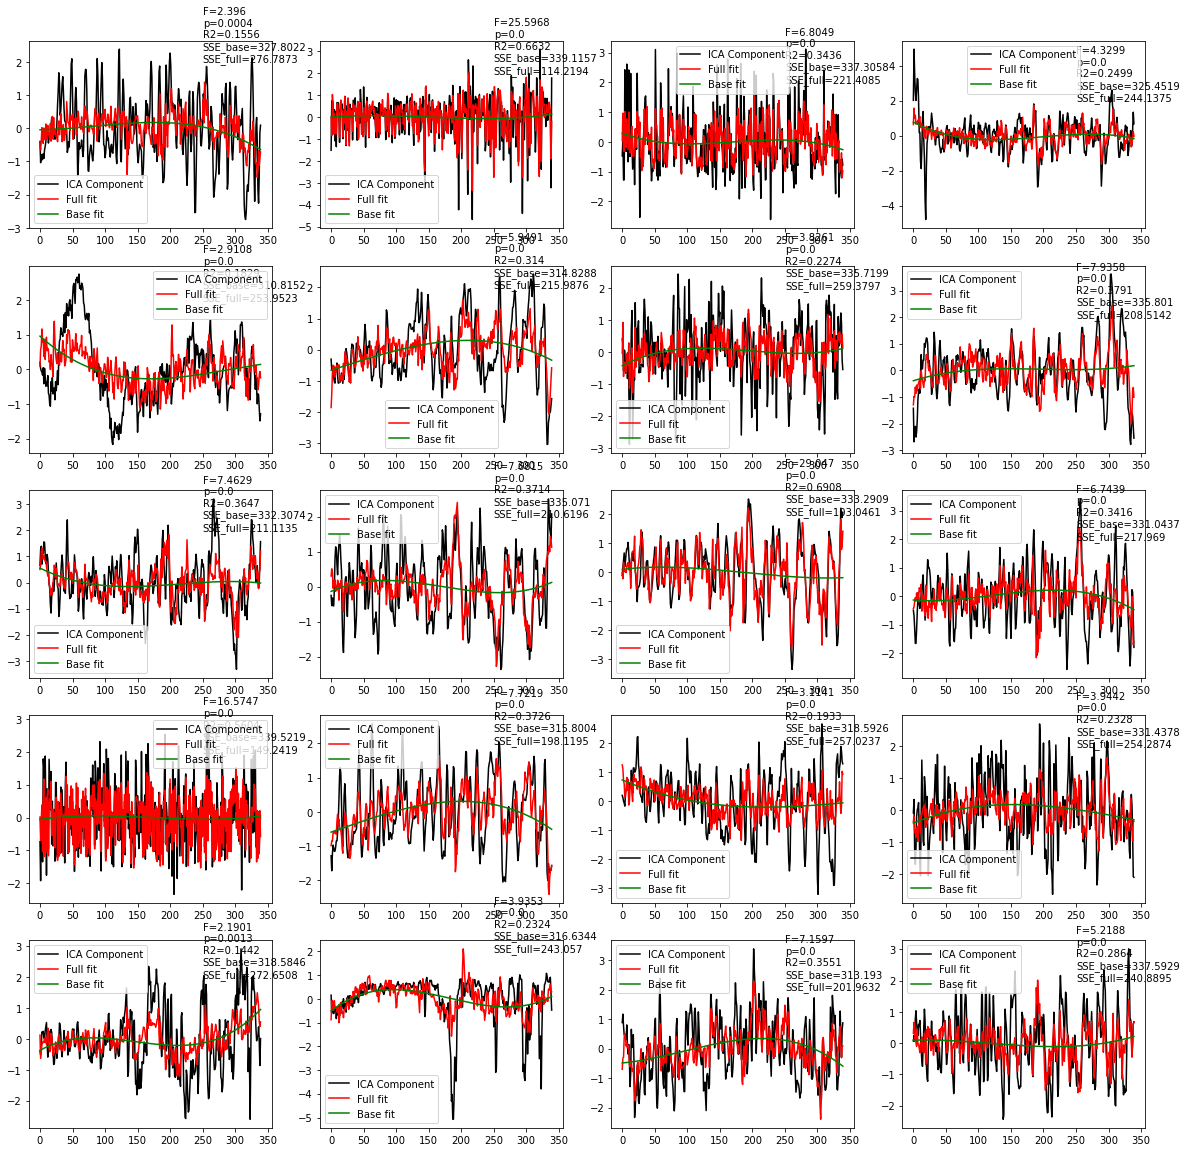

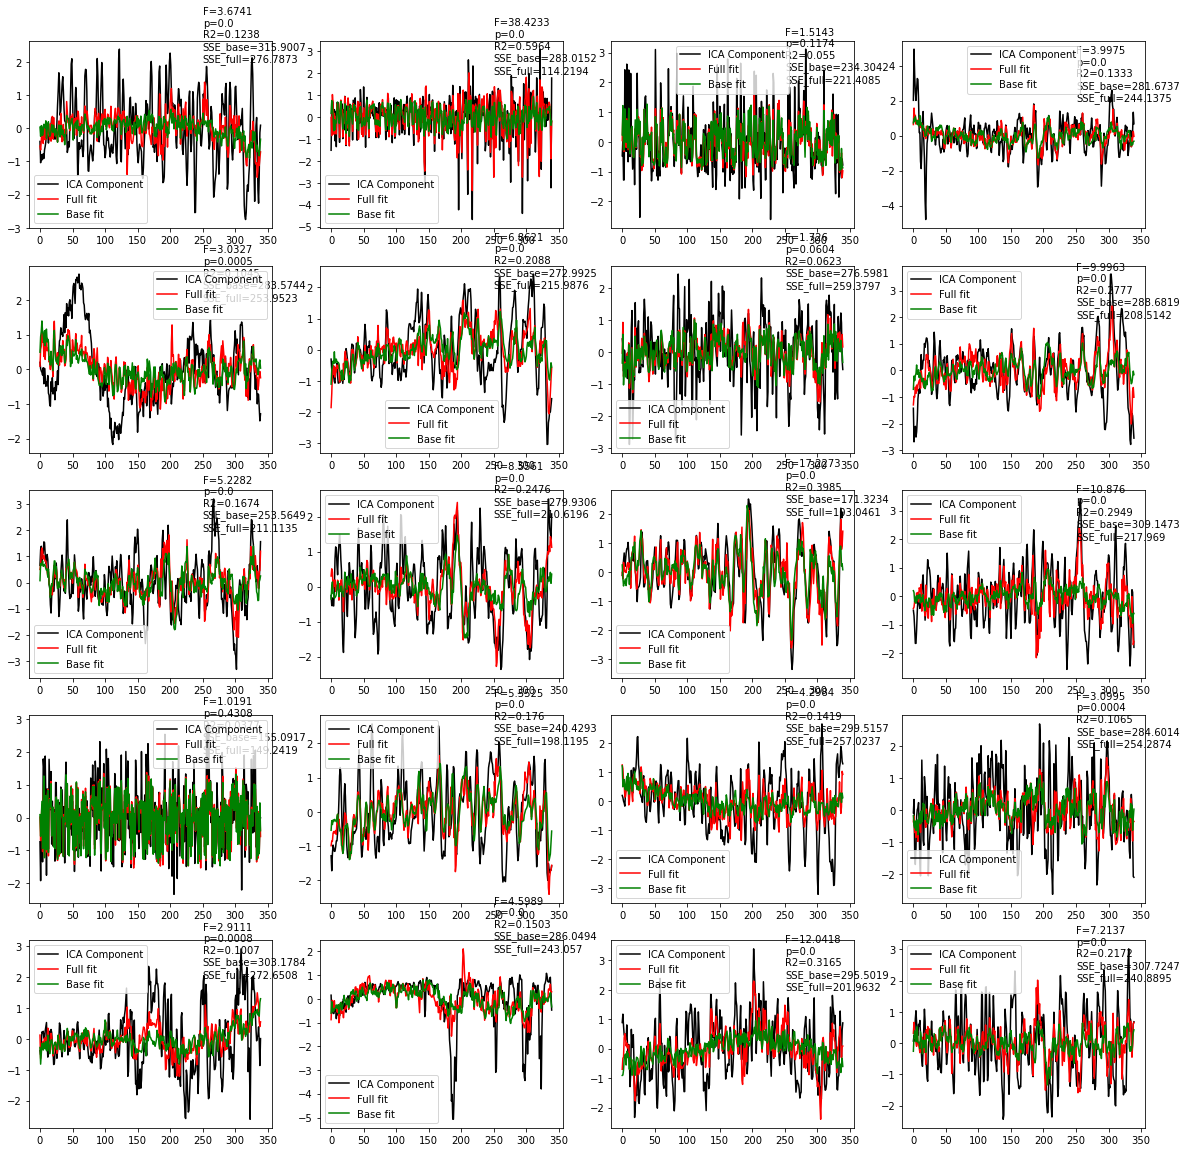

In [5]:
# Run the fits and see the plotted results

# TestRegress defines the model, as mentioned above, it's really ugly and I should probably rethink how I'm doing it.
TestRegress = {"Motion": {"_dmn", "_drv"}, "Phys_Freq": {"_sin", "_cos"}, "Phys_Variability": {"_rvt", "_hrv"}, "WM & CSF": {"WM_e", "Csf_vent"}}
# Fit the models and calculate signficance
linear_model(ica_table, noise_regress_table, polort=True, TestRegress=TestRegress)
# In the output below, the first series of subplots is the full model vs the baseline of the polort detrending regressors for the first 20 components
# The second series of suplots is the full model vs the full model excluding motion regressors (which shows the significant of motion regressors)
# One thing I'm noticing is that a lot of these seem significant. To be conservative, we might want to set agressive thresholds or only reject
#   components with a significantly low p AND a R2 that high enough to show that the noise regressors account for a substantial amount of
#   the variance in the ICA component

In [ ]:
# NOT CURRENTLY USING, BUT NEED TO USE TO PUT EVERYTHING BACK TOGETHER
def main():
    """
    Implements multiple linear modeling & multivariate modeling

    Inputs (multiple):
    Regressor pandas dataframe:
    6 motion params (demeaned), 1st derivatives of 6 motion parameters (deriv), 
    2 cardiac RETROICOR regressors, 2 resp RETROICOR regressors,
    1 HRV regressor, 1 RVT regressor

    Output (1):
    ICA component

    Linear Model:
    Y = MX + e
    Y = fit to ICA component time series (CxT) -> 1 dependent variable (prediction of fit to Y-variable)
    M = coefficient matrix you’re solving for (CxN) -> 
    X = all the above regressors and a row of ones for the intercept) (NxT) -> multiple independent variables
    e = error

    equation:  y = A+B1x1+B2x2+B3x3+B4x4

    C=# of components
    T=Time
    N=number of nuisance regressors
    """

    """
    sub=sub-01
    task=wnw
    run=1

    Parser call:
    python3 /Users/holnessmn/Desktop/BIDS_conversions/Linear_Model.py \
    --regressors /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_RegressorModels_${task}_run-${run}.tsv \
    --ica_mixing /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/ica_mixing.tsv \
    --prefix /Users/holnessmn/Desktop/BIDS_conversions/${sub}_physios/${task}/run${run}/${sub}_LinearModel_${task}_run-${run}

    """

    parser = argparse.ArgumentParser()
    parser.add_argument("--regressors", dest="regressors", help="Regressor Model file", type=str)
    parser.add_argument("--ica_mixing", dest="ica_mixing", help="ICA mixing matrix", type=str)
    parser.add_argument("--prefix", dest="prefix", help="File Prefix & redirected output", type=str)

    ARG = parser.parse_args()

    if ARG.regressors and os.path.isfile(ARG.regressors):
        regress = ARG.regressors
    else:
        raise Exception(f"This file/filepath {ARG.regressors} does not exist!!!")

    if ARG.ica_mixing and os.path.isfile(ARG.ica_mixing):
        ica = ARG.ica_mixing
    else:
        raise Exception(f"This file/filepath {ARG.ica_mixing} does not exist!!!")

    if ARG.prefix and type(ARG.prefix) == str:
        prefix = ARG.prefix
    else:
        raise Exception(f"Not a string {ARG.prefix} !!!")


    # General question: How does each X-regressor (noise model) match each Y-comp (ICA component ts)?

    # Y-Data #
    # Read in the ICA components
    ica_table = pd.read_csv(ica, sep='\t')
    # ['ICA_00','ICA_01',...]
    # ica_tsv.columns
    # multi-dimensional list with each component timeseries as sub-list, len = Num of timesteps/volumes
    # icamix = ica_tsv.to_numpy()
    #icamixlist = [ica_tsv[i] for i in ica_tsv.columns]     

    print("Size of ICA mixing matrix: ", ica_table.shape)

    # X-Data #
    # Read in the Noise Regressors          (24 noise regressors + intercept ts), len = 25
    noise_regress_table = pd.read_csv(regress, sep='\t')
    # Regressor models ['cardiac_sin1','cardiac_cos1',...'WM_e','Csf_vent']
    # regres_tsv.columns
    # multi-dimensional list with each regressor timeseries as sub-list, len = Num of timesteps/volumes (indexed by TRs...)
    # noise_regress = regres_tsv.to_numpy()

    print(f"Size of noise regressors: {noise_regress_table.shape}")

    #visual_check(icamixlist, nphlmlist)
    
    TestRegress = ["_dmn", "_drv", {"_sin", "_cos"}, {"_rvt", "_hrv"}, {"WM_e", "Csf_vent"}]
    # Fit the models and calculate signficance
    coefficient_matrix, R_sq, pvals = linear_model(ica_table, noise_regress_table, polort=True, TestRegress=TestRegress)
    
    

    convert(coefficient_matrix, R_sq, pvals, prefix)
    significant_ICs()
